# under construction

**Goal:** 
...  

**Usage:**  
...  
**Dataset:** 
...  
**Content:**
* ...


| [open in colab](TODO_link)



In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


#### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.7.0
TF  Version 2.0.0-alpha0


### Working with a TFP Normal distribution

In [4]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
import tensorflow_probability as tfp
tfd = tfp.distributions
d = tfd.Normal(loc=[3], scale=1.5)           #A
x = d.sample(2) # Draw two random points.    #B
px = d.prob(x) # Compute density/mass.       #C
print(x)
print(px)
#A create a 1D Normal distribution with mean 3 and standard deviation 1.5
#B sample 2 realizations from the Normal distribution
#C compute the likelihood for each of the two sampled values under the defined Normal distribution 

tf.Tensor(
[[3.4912028]
 [1.7360613]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[0.2520768 ]
 [0.18648346]], shape=(2, 1), dtype=float32)


### Simulate the fishlike data

In the next few cells you will simulate some data that looks like a fish.You will fist simulate random distributed noise with non constant varaiance, then uniformly distributed x values between -1 and 6 and finally calculate corresponding y values with y= 2.7*x+noise (linear slope of 2.7 and intercept of 0) . The variance of the noise will change, it starts with high value of 12 and gets smaller until it is reaches a constant value of 1, then it grows again until a value of 15 to stay constant for a while and to decrease to 1 again. Look at the plot to understand the behavior of the variance. Let's sample random distributed noise with that variance. 

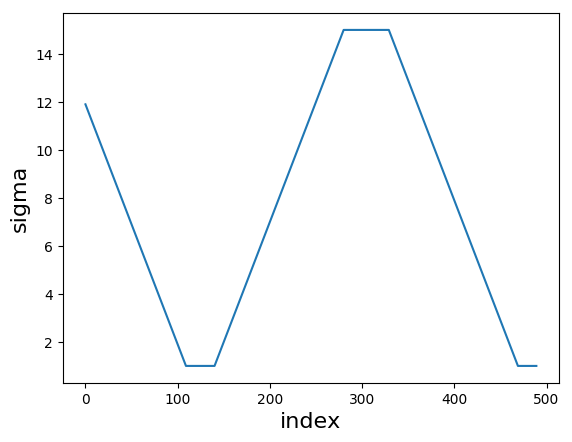

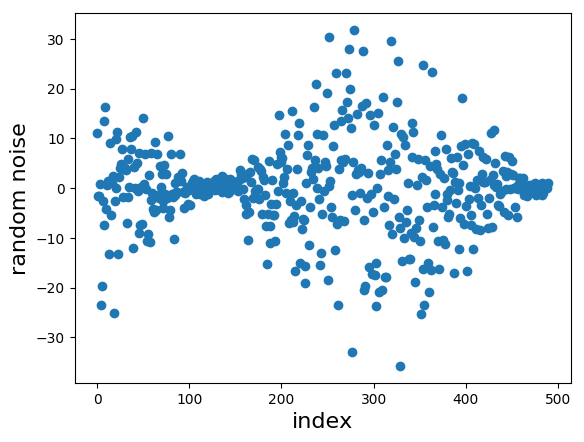

In [5]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()

np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
#plot the noise that you add to a linear regression
plt.scatter(np.arange(0,len(noise),1),noise)
plt.xlabel("index",size=16)
plt.ylabel("random noise",size=16)#pred
plt.show()


Now you will sample random uniformly distributed x values in the range from -1 to 6. you will sample less x values in the range from -1 to 1 which will be the first part of the random distributed variance where the noise is decrasing. The dataset will have more x values in the range from 1 to 6 than in the range from -1 to 1. You will generate as much x values as we have random noise points. Finally you want to sort the x values (for ploting reasons). 

In [0]:
# generation the x values for the simulated data
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)

Let's put it all together to make the simulated fishlike data comple. You calculate y from the x values and the noise with a linear function where the slope is 2.7 and the intercept is 0, y=2.7*x+noise.  

In [0]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [0]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

#### Split data in train and test

In the next cells you will spilt the data x and y into a training, validation and test set. To get a first train and test dataset you just randomly sample 25% of the x and y values in the test dataset and the rest is the training dataset. The resulting training dataset gets splitted again into a training and validation dataset (80% training and 20% validation). After the splitting of the dataset you need to make sure that all the x values  from every dataset are in increasing order for ploting reasons (note that you also need to reorder the corresponding y values for all datasets).

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))


nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


In [0]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]


Let's plot the training and validation data. You can see that it really looks a bit like a fish. In the following cells you will train diffrent models on the training data, validate the loss (NLL) on the validation data and in the end you will predict the testdata with the best model (lowest NLL on the validation dataset). It's important to keep the testdata in a locked safe, because in practice it is unknown, until you decide which model you want to use to make a prediction for it. That is the reason why you will plot it only in the end.

(-30, 55)

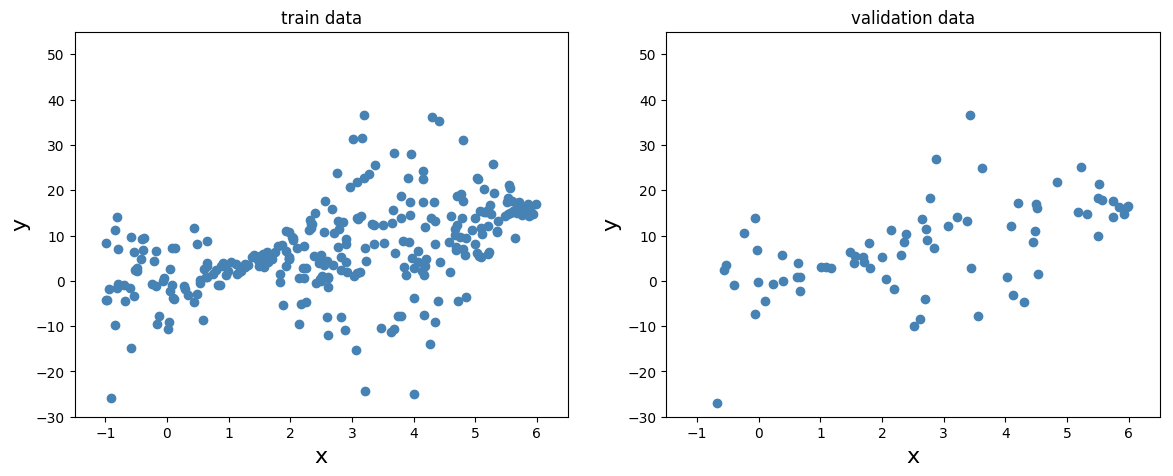

In [11]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

## Fit linear regression with constant variance (sigma = 1)

In [12]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
def NLL(y, distr): 
  return -distr.log_prob(y) #A

def my_dist(params): #B
  return tfd.Normal(loc=params, scale=1)

inputs = Input(shape=(1,))
params = Dense(1)(inputs)#C

dist = tfp.layers.DistributionLambda(my_dist)(params) #D
model_sd_1 = Model(inputs=inputs, outputs=dist)
model_sd_1.compile(Adam(learning_rate=0.01), loss=NLL) #E

#A Function to compute the NLL of an observed y under the fitted distribution distr. 
#B Function to utilize the output of the last layer (params) as the parameter(s) of a distribution
#C Setting up the NN with one output node
#D Calling a distributional layer to take the function my_dist with arguments params.  
#E Compiling the model with NLL as loss function

model_sd_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_sd_1.fit(x_train, y_train, epochs=1000, verbose=0, validation_data=(x_val,y_val))

In [0]:
model_mean_sd_1 = Model(inputs=inputs, outputs=dist.mean())

Text(0.5, 0, 'Epochs')

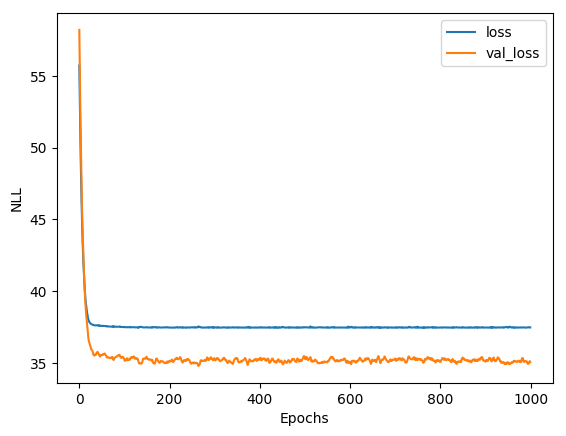

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

In [16]:
print(model_sd_1.evaluate(x_train,y_train))
print(model_sd_1.evaluate(x_val,y_val))

293/293 [==============================] - 0s 72us/sample - loss: 37.4625
37.46249792681619
74/74 [==============================] - 0s 142us/sample - loss: 35.0520
35.05202555012058


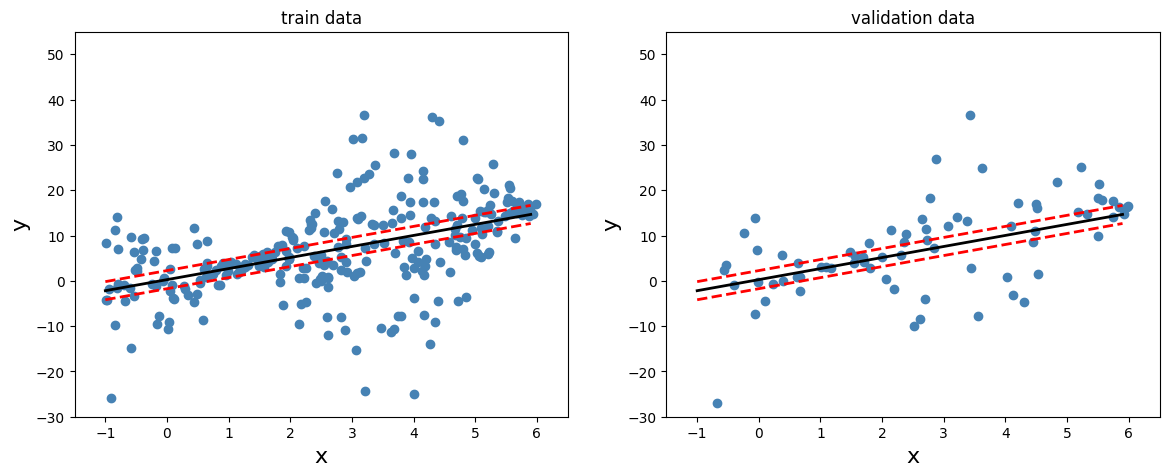

In [62]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_1.predict(x_pred)
sigma = 1
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

### Does the NLL depend on sigma, What happens with mu?

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 1: Change the constant variance sigma in the network form 1 to 5, retrain the network and calculate the NLL for the training and validation data with model.evaluate() function. What do you observe, is the NLL independent of sigma? What would be the optimal sigma that leads to the lowest NLL?
What do you obserce for the mu values with constant simga 1 and 5?*

In [0]:
# Write your code here

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

In [19]:

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
def NLL(y, distr): 
  return -distr.log_prob(y) #A

def my_dist(params): #B
  return tfd.Normal(loc=params, scale=5)

inputs = Input(shape=(1,))
params = Dense(1)(inputs)#C

dist = tfp.layers.DistributionLambda(my_dist)(params) #D
model_sd_5 = Model(inputs=inputs, outputs=dist)
model_sd_5.compile(Adam(learning_rate=0.01), loss=NLL) #E

#A Function to compute the NLL of an observed y under the fitted distribution distr. 
#B Function to utilize the output of the last layer (params) as the parameter(s) of a distribution
#C Setting up the NN with one output node
#D Calling a distributional layer to take the function my_dist with arguments params.  
#E Compiling the model with NLL as loss function

model_sd_5.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_sd_5.fit(x_train, y_train, epochs=1000, verbose=0, validation_data=(x_val,y_val))

In [0]:
model_mean_sd_5 = Model(inputs=inputs, outputs=dist.mean())

Text(0.5, 0, 'Epochs')

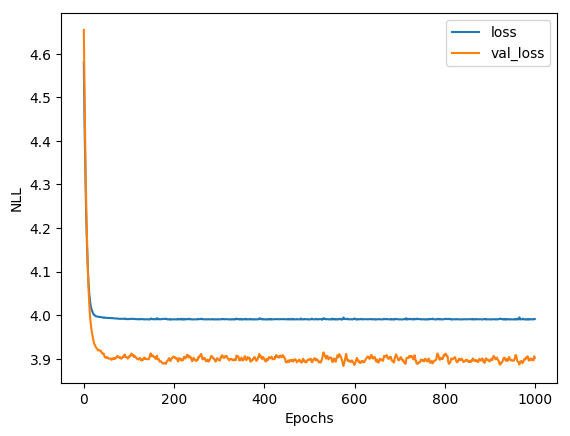

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

In [23]:
print(model_sd_5.evaluate(x_train,y_train))
print(model_sd_5.evaluate(x_val,y_val))

293/293 [==============================] - 0s 43us/sample - loss: 3.9900
3.990004853583847
74/74 [==============================] - 0s 61us/sample - loss: 3.9012
3.901243712451007


In [24]:
(model_mean_sd_1.predict(x_train)-model_mean_sd_5.predict(x_train))[0:5]

array([[-0.04622102],
       [-0.04619503],
       [-0.04534054],
       [-0.04384601],
       [-0.0428623 ]], dtype=float32)

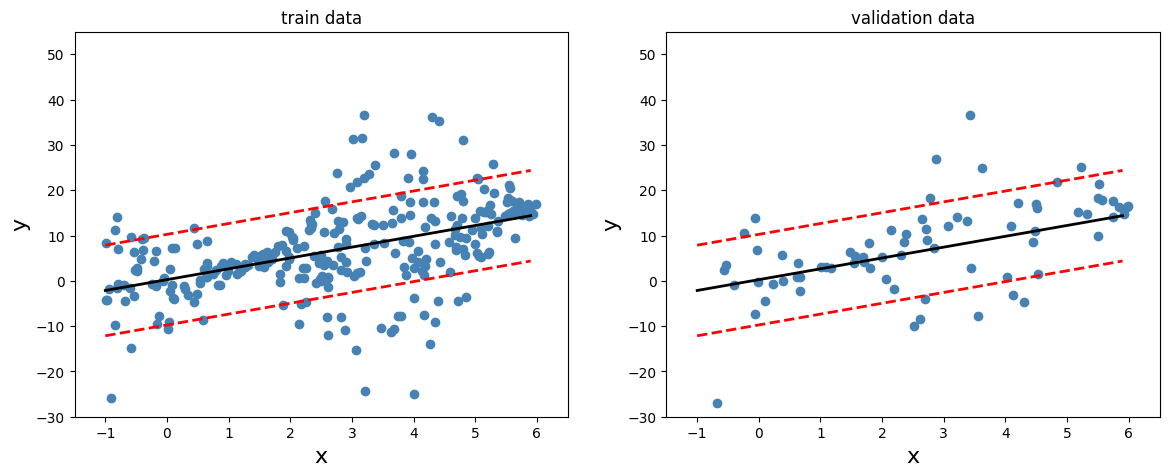

In [64]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)


plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_5.predict(x_pred)
sigma = 5
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


In [26]:
preds_train = model_mean_sd_5.predict(x_train)
preds_val = model_mean_sd_5.predict(x_val)

SSR= np.sum(np.square(y_train-preds_train))
sigma_=np.sqrt((SSR)/(len(x_train)-2))
sigma_

8.578093332700467

In [72]:
#loss with the estimated sigma
NLL_train=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                  ((np.square(y_train-model_mean_sd_5.predict(x_train))/(2*np.square(sigma_)))))
print(NLL_train)
NLL_val=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(sigma_))))+
                ((np.square(y_val-model_mean_sd_5.predict(x_val))/(2*np.square(sigma_)))))
print(NLL_val)

3.564737230430251
3.5345806968724736


In [73]:
import scipy.stats
print(np.mean(-np.log(scipy.stats.norm(model_mean_sd_5.predict(x_train), sigma_).pdf(y_train))))
print(np.mean(-np.log(scipy.stats.norm(model_mean_sd_5.predict(x_val), sigma_).pdf(y_val))))

3.564737230430251
3.5345806968724736


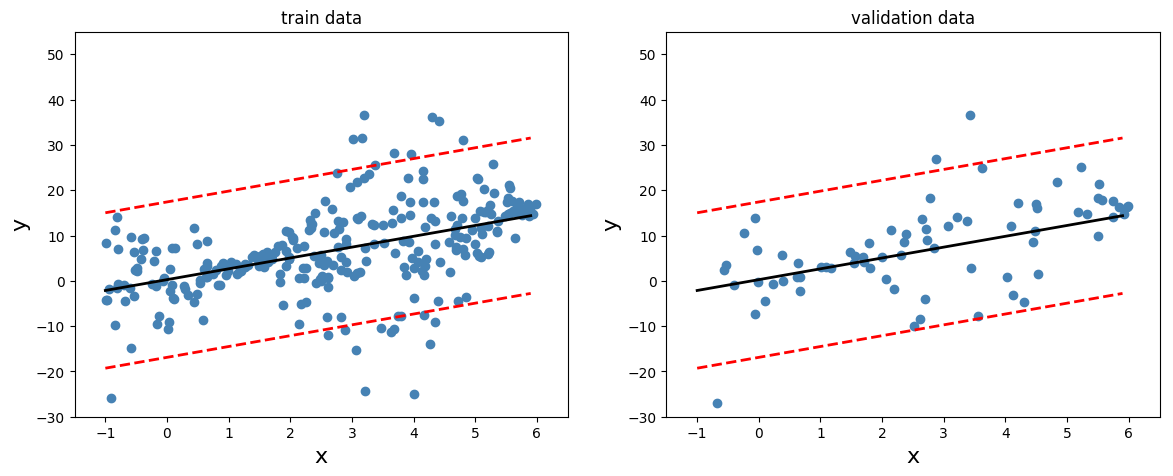

In [65]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_mean_sd_5.predict(x_pred)
sigma = sigma_
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*sigma,color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*sigma,color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


## Fit linear regression allow the sd to depend in a monotonic way on the input

In [0]:
# montonic sd change
#model = tf.keras.Sequential() 
#model.add(tf.keras.layers.Dense(2,input_shape=(1,))) #B
#model.add(tfp.layers.DistributionLambda(  
#       ) #D
#model.compile(Adam(learning_rate=0.01), loss=NLL) 

def NLL(y, distr):
  return -distr.log_prob(y) #A

inputs = Input(shape=(1,))
params = Dense(2)(inputs)#C

dist = tfp.layers.DistributionLambda( lambda t: tfd.Normal(loc=t[:,0:1], #C
        scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))(params) #D
model_monotoic_sd = Model(inputs=inputs, outputs=dist)
model_monotoic_sd.compile(Adam(learning_rate=0.01), loss=NLL) #E


In [32]:
model_monotoic_sd.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
distribution_lambda_2 (Distr ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model_monotoic_sd.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val,y_val))

In [0]:
model_monotoic_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_monotoic_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

Text(0.5, 0, 'Epochs')

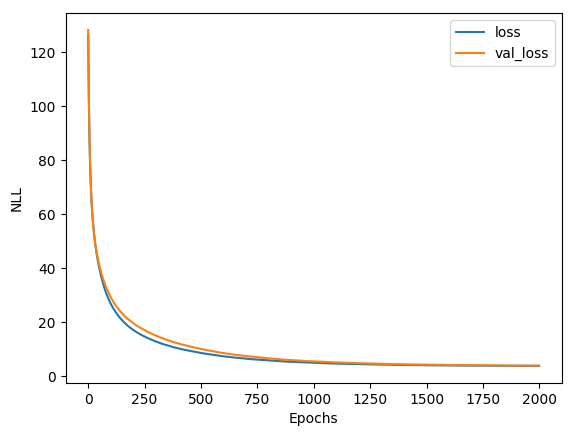

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

In [36]:
print(model_monotoic_sd.evaluate(x_train,y_train))
print(model_monotoic_sd.evaluate(x_val,y_val))

293/293 [==============================] - 0s 59us/sample - loss: 3.6549
3.6549358034296655
74/74 [==============================] - 0s 91us/sample - loss: 3.7571
3.75712039663985


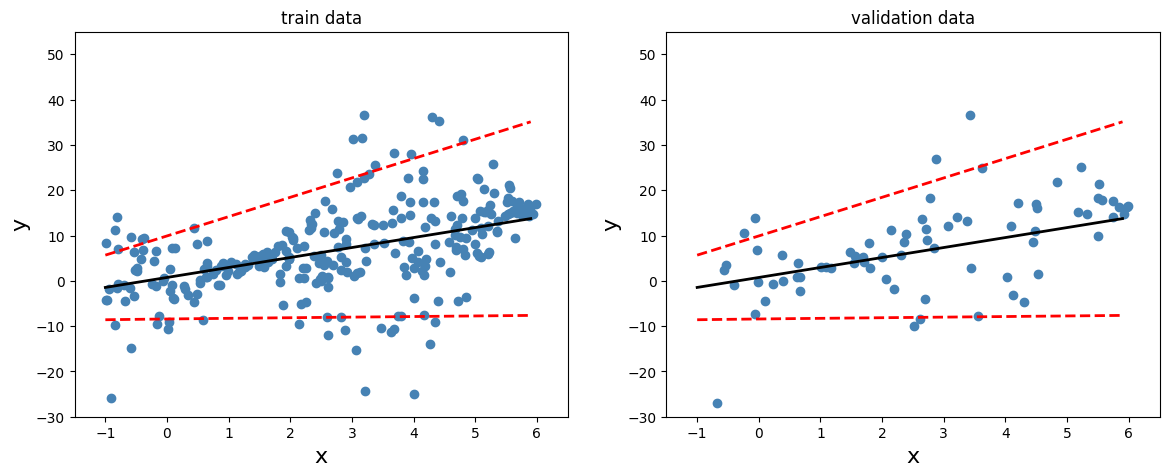

In [66]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_monotoic_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_monotoic_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

## Fit a linear regression and allow the sd to depend in a flexible manner on the input

In [0]:
def NLL(y, rv_y):
  return -rv_y.log_prob(y) #A

inputs = Input(shape=(1,))
out1 = tf.keras.layers.Dense(1)(inputs)
hidden1 = tf.keras.layers.Dense(20,activation="relu")(inputs)
hidden2 = tf.keras.layers.Dense(10,activation="relu")(hidden1)
out2 = tf.keras.layers.Dense(1)(hidden2)
out = tf.keras.layers.Concatenate()([out1,out2])
dist = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, 0:1],scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))(out)

model_flex_sd = Model(inputs=inputs, outputs=dist)
model_flex_sd.compile(Adam(), loss=NLL)


In [39]:
model_flex_sd.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 20)           40          input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 10)           210         dense_4[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1)            2           input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
history = model_flex_sd.fit(x_train, y_train, epochs=4000, verbose=0, validation_data=(x_val,y_val))

In [0]:
model_flex_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_flex_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

Text(0.5, 0, 'Epochs')

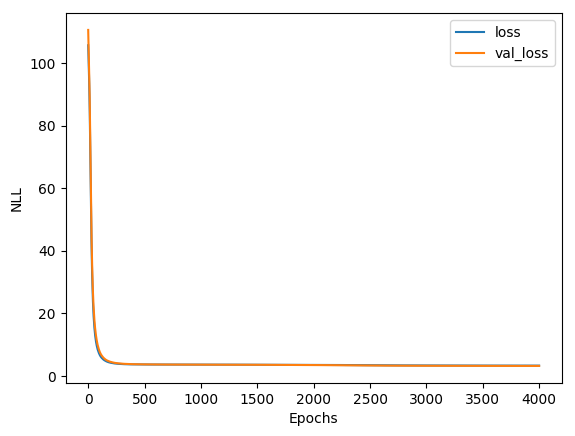

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

In [43]:
print(model_flex_sd.evaluate(x_train,y_train))
print(model_flex_sd.evaluate(x_val,y_val))

293/293 [==============================] - 0s 55us/sample - loss: 3.2014
3.2013786424955817
74/74 [==============================] - 0s 68us/sample - loss: 3.1069
3.1068846212851033


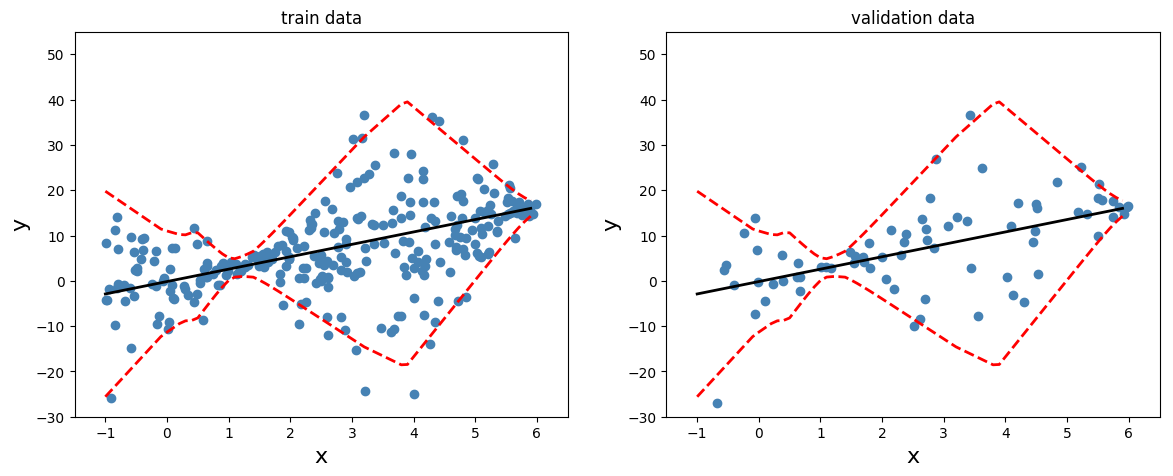

In [67]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

### Prediction of the test with the best model

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 2: Which of the models above that have used is the best for new unseed data? Use this model to predict the test set and calculate the NLL for the test set. Is the NLL in the range that you expected?*

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

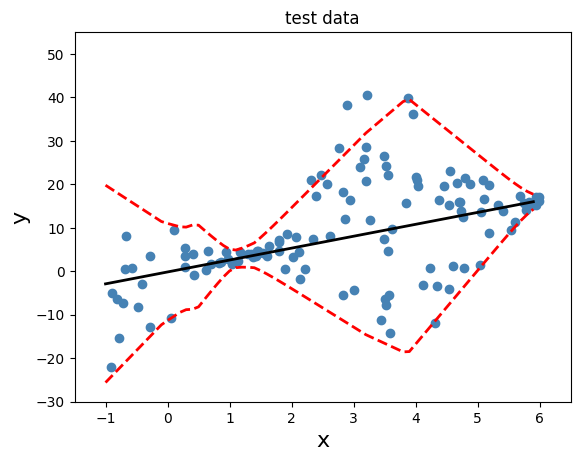

In [68]:
plt.scatter(x_test,y_test,color="steelblue") #observerd 
x_pred = np.arange(-1,6,0.1)
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("test data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

In [69]:
model_flex_sd.evaluate(x_test,y_test)

123/123 [==============================] - 0s 109us/sample - loss: 3.2050


3.2049701969798017

In [70]:
np.mean(-model_flex_sd(x_test).log_prob(y_test))

3.2049704

In [71]:
NLL_test=np.mean(-np.log(1/(np.sqrt(2*np.pi*np.square(model_flex_sd_sd.predict(x_test)))))+
                 ((np.square(y_test-model_flex_sd_mean.predict(x_test))/(2*np.square(model_flex_sd_sd.predict(x_test))))))
print(NLL_test)

3.2049702795925588


### Prediction outside the x range

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Optinal Exercise 3:Predict the mean and sigma for a x-range from -5 to 10. What do you observe?*

Scroll down to see the solution.

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

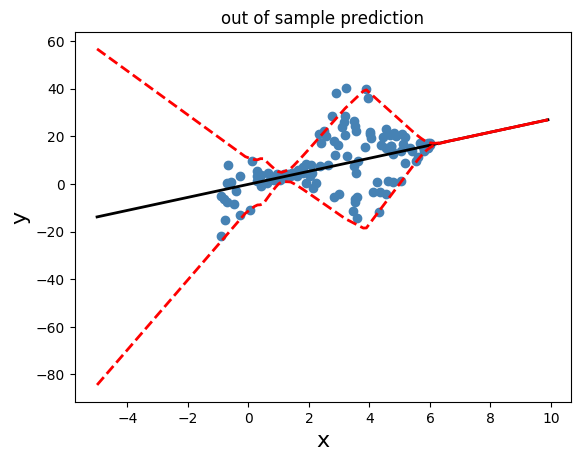

In [55]:
plt.scatter(x_test,y_test,color="steelblue") #observerd 
x_new=np.arange(-5,10,0.1)
preds_new = model_flex_sd_mean.predict(x_new)
plt.plot(x_new,preds_new,color="black",linewidth=2)
plt.plot(x_new,preds_new+2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2) 
plt.plot(x_new,preds_new-2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("out of sample prediction")
plt.show()

In [0]:
from google.colab import files
data=np.column_stack([x_train,y_train,model_mean_sd_5.predict(x_train),np.repeat(sigma_,len(x_train)),
                 model_monotoic_sd_mean.predict(x_train),model_monotoic_sd_sd.predict(x_train),
                 model_flex_sd_mean.predict(x_train),model_flex_sd_sd.predict(x_train)])
import pandas as pd
train=pd.DataFrame(data,columns=["x_train","y_train","mu_const","sigma_const","mu_monotonic","sigma_monotonic","mu_flex","sigma_flex"])
train.to_csv("ch05_01_train.csv",sep=",",index=False,header=True)
files.download('ch05_01_train.csv') 

In [0]:
from google.colab import files
data=np.column_stack([x_val,y_val,model_mean_sd_5.predict(x_val),np.repeat(sigma_,len(x_val)),
                 model_monotoic_sd_mean.predict(x_val),model_monotoic_sd_sd.predict(x_val),
                 model_flex_sd_mean.predict(x_val),model_flex_sd_sd.predict(x_val)])
import pandas as pd
train=pd.DataFrame(data,columns=["x_val","y_val","mu_const","sigma_const","mu_monotonic","sigma_monotonic","mu_flex","sigma_flex"])
train.to_csv("ch05_01_val.csv",sep=",",index=False,header=True)
files.download('ch05_01_val.csv') 

In [0]:
from google.colab import files
data=np.column_stack([x_test,y_test,model_mean_sd_5.predict(x_test),np.repeat(sigma_,len(x_test)),
                 model_monotoic_sd_mean.predict(x_test),model_monotoic_sd_sd.predict(x_test),
                 model_flex_sd_mean.predict(x_test),model_flex_sd_sd.predict(x_test)])
import pandas as pd
train=pd.DataFrame(data,columns=["x_test","y_test","mu_const","sigma_const","mu_monotonic","sigma_monotonic","mu_flex","sigma_flex"])
train.to_csv("ch05_01_test.csv",sep=",",index=False,header=True)
files.download('ch05_01_test.csv') 

In [0]:
### aufgabe für sinus, spliting selber, netz vorgen, hidden dazu oder nicht? 
### fragen wie man das am besten modelieren soll